<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/SARIMAX_OR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX




from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

In [23]:
df = pd.read_csv('/content/BE.csv')
df.drop(df.loc[df['Date'].duplicated()].index, inplace = True)
#df['datetime'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['Date'], inplace = True)
df.drop(columns = [ 'Date'], inplace = True)

In [24]:
df

,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09 00:00:00,32.54,63065.0,63000.0
2011-01-09 01:00:00,21.55,62715.0,58800.0
2011-01-09 02:00:00,15.71,61952.0,58500.0
2011-01-09 03:00:00,10.58,59262.0,54300.0
2011-01-09 04:00:00,10.32,56883.0,51900.0
...,...,...,...
2016-12-31 19:00:00,40.84,70329.0,73957.0
2016-12-31 20:00:00,40.10,69121.0,72544.0
2016-12-31 21:00:00,36.00,66647.0,69451.0


In [25]:
#steps=24
dataset_for_prediction= df.copy()
#dataset_for_prediction[' Prices']=dataset_for_prediction[' Prices',' Generation forecast', ' System load forecast'].shift(-steps)
#dataset_for_prediction=dataset_for_prediction.dropna()

In [26]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[[' Prices',' Generation forecast', ' System load forecast']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[[' Prices']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [27]:
list( dataset_for_prediction.columns)

[' Prices', ' Generation forecast', ' System load forecast']

In [28]:
X.rename(columns = {0:' Prices',
 1:' Generation forecast',
 2:' System load forecast',}, inplace = True)

In [29]:
X.index = dataset_for_prediction.index
X.drop(columns = ' Prices', inplace = True)

y.rename(columns={0:'Electricity price in 24 hours'}, inplace= True)
y.index=dataset_for_prediction.index

In [30]:
train_X, train_y = X[24:34944], y[24:34944] 
test_X, test_y = X[34944:].dropna(), y[34944:].dropna()

In [31]:
test_X

,Generation forecast,System load forecast
Date,,
2015-01-04 00:00:00,0.593798,0.524101
2015-01-04 01:00:00,0.550742,0.454649
2015-01-04 02:00:00,0.539510,0.453230
2015-01-04 03:00:00,0.486813,0.399761
2015-01-04 04:00:00,0.464946,0.361348
...,...,...
2016-12-31 19:00:00,0.615864,0.635632
2016-12-31 20:00:00,0.595852,0.615787
2016-12-31 21:00:00,0.554867,0.572346


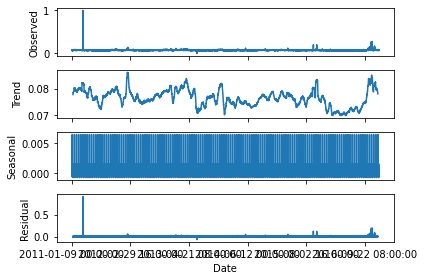

In [32]:
seas_d=sm.tsa.seasonal_decompose(y,model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [33]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout['critical value {}'.format(key)]=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)
        
y_test=y['Electricity price in 24 hours'][24:52380].dropna()
test_adf(y_test, " Electricity Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Electricity Price


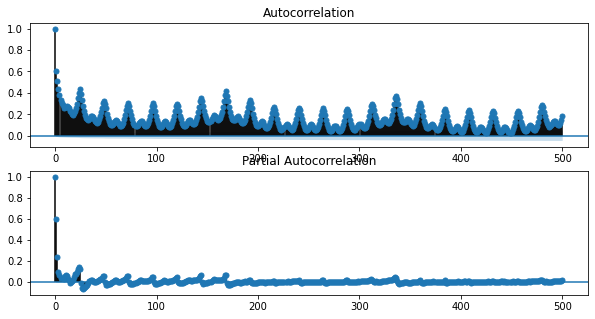

In [34]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=500, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=500, ax=ax[1])
plt.show()

In [35]:
!sudo pip install pmdarima
from pmdarima.arima import auto_arima

In [36]:
 step_wise = auto_arima(train_y, 
     exogenous= train_X,
     start_p=0, start_q=0, 
     max_p=5, max_q=5, 
     d=1, max_d=168,
     n_jobs = -1,
     start_Q=0,
     max_P=5,
     max_D=5,
     max_Q=5,
     seasonal = True,
     stationary = True,
     trace=True, 
     error_action='ignore', 
     suppress_warnings=True, 
     random = True,
     stepwise=False)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Best model:  ARIMA(1,0,3)(0,0,0)[1] intercept
Total fit time: 349.281 seconds


In [37]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                34920
Model:               SARIMAX(1, 0, 3)   Log Likelihood              131404.716
Date:                Tue, 22 Feb 2022   AIC                        -262793.433
Time:                        15:36:19   BIC                        -262725.746
Sample:                    01-10-2011   HQIC                       -262771.871
                         - 01-03-2015                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.0014   8.18e-05     16.723      0.000       0.001       0.002
 Generation forecast      0.0367      0.002     14.745      0.000       0.032       0.042
 System load forecast     0.0020      0.002      0.843      0.399      -0.003       0.007
ar.L1                     0.9771      0.001    765.172      0.000       0.975       0.980
ma.L1                    -0.7030      0.001   -530.173      0.000      -0.706      -0.700
ma.L2                    -0.0818      0.001   -148.470      0.000      -0.083      -0.081
ma.L3                    -0.0583      0.001    -67.274      0.000      -0.060      -0.057
sigma2                 3.149e-05   8.37e-09   3760.736      0.000    3.15e-05    3.15e-05
===================================================================================
Ljung-Box (Q):                      578.15   Jarque-Bera (JB):      577212818081.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                           119.69
Prob(H) (two-sided):                  0.00   Kurtosis:                     19919.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
model= SARIMAX(train_y, 
 exog=train_X,
 order=(1,0,3),
enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  periods=len(index) + 1,


In [41]:
results=model.fit()

forecast = results.forecast(steps=17472, exog = test_X)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


In [45]:
train_size = 34944
test_size = 52416
steps = -24

In [46]:
y


,Electricity price in 24 hours
Date,
2011-01-09 00:00:00,0.072691
2011-01-09 01:00:00,0.069256
2011-01-09 02:00:00,0.067430
2011-01-09 03:00:00,0.065827
2011-01-09 04:00:00,0.065746
...,...
2016-12-31 19:00:00,0.075286
2016-12-31 20:00:00,0.075055
2016-12-31 21:00:00,0.073773


In [47]:
predictions= results.predict(start = 34944, end=52416+(steps)-1 ,exog=test_X)

In [48]:
forecast_electricity= pd.DataFrame(forecast)
forecast_electricity.reset_index(drop=True, inplace=True)
forecast_electricity.index=test_X.index
forecast_electricity['Actual'] =scaler_output.iloc[34944:, 0]
forecast_electricity.rename(columns={0:'Forecast'}, inplace=True)

In [49]:

forecast_electricity['Forecast']

Date
2015-01-04 00:00:00    0.073039
2015-01-04 01:00:00    0.071240
2015-01-04 02:00:00    0.070888
2015-01-04 03:00:00    0.068904
2015-01-04 04:00:00    0.067983
                         ...   
2016-12-31 19:00:00    0.035084
2016-12-31 20:00:00    0.034335
2016-12-31 21:00:00    0.032783
2016-12-31 22:00:00    0.032250
2016-12-31 23:00:00    0.033170
Name: Forecast, Length: 17472, dtype: float64

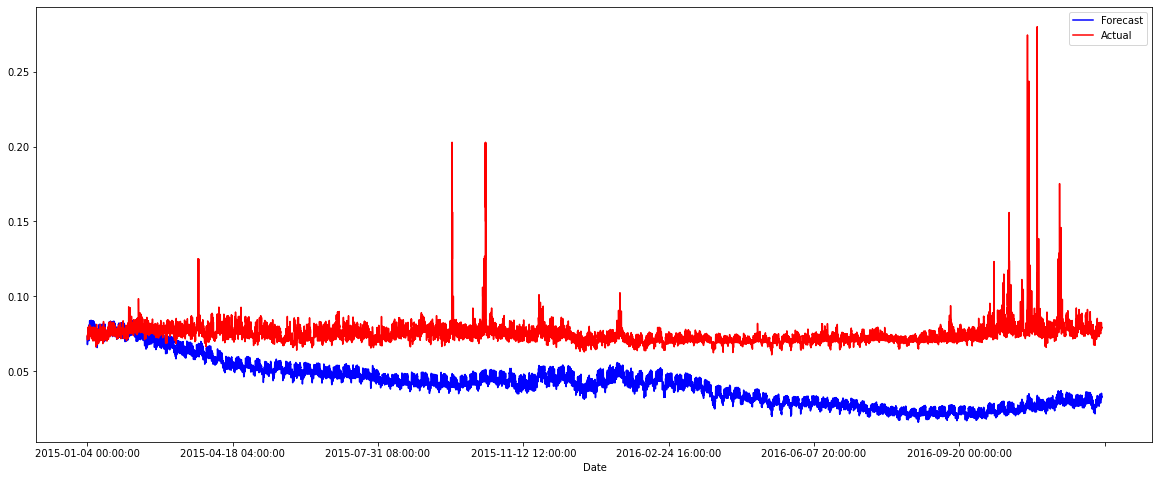

In [51]:
forecast_electricity['Forecast'][:17448].plot(figsize=(20,8), legend=True, color='blue')
forecast_electricity['Actual'][:17448].plot(legend=True, color='red', figsize=(20,8))

In [52]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [53]:
mape = mean_absolute_percentage_error(forecast_electricity['Actual'], forecast_electricity['Forecast'])
mape

44.09051491119426

In [54]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [55]:
act.head()

,Electricity price in 24 hours
Date,
2015-01-04 00:00:00,0.073854
2015-01-04 01:00:00,0.072610
2015-01-04 02:00:00,0.071157
2015-01-04 03:00:00,0.070969
2015-01-04 04:00:00,0.070972


In [56]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X[24:].index
predictions['Actual'] = act['Electricity price in 24 hours']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [57]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [58]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])


unscaled = pd.DataFrame(testPredict)
unscaled['actual'] = testActual
unscaled = unscaled.rename(columns={0: 'predictions'})

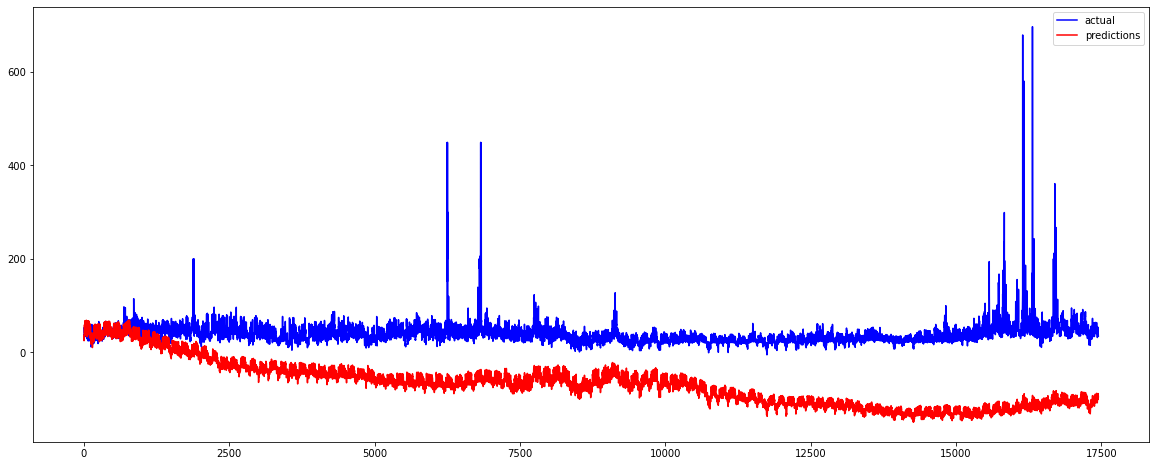

In [75]:
unscaled['actual'].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'].plot(legend=True, color='red', figsize=(20,8))

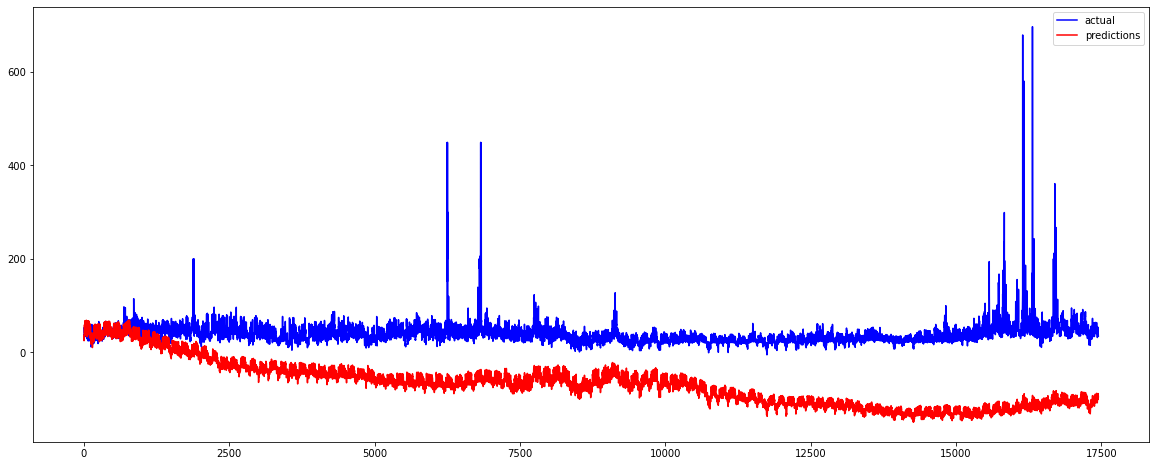

In [60]:
unscaled['actual'][-17448:].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][-17448:].plot(legend=True, color='red', figsize=(20,8))

In [85]:
#Save pred results
import csv 
unscaled = pd.DataFrame(unscaled)
unscaled.to_csv("Unscaled_SARIMA_rslts.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')


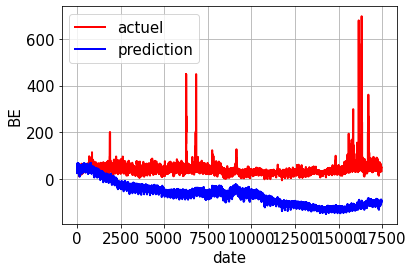

In [81]:

original=unscaled['actual']
pred=unscaled['predictions']
plt.plot(original,'r',lw =2)
plt.plot(pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('SARIMA', figsize=(20,8), transparent=True, dpi=300)

# **XGBoost**

In [61]:
!sudo pip install xgboost

In [62]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [63]:
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.005975538838033057
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'n_jobs': -1, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [64]:
xgbbest = xgb.XGBRegressor(min_child_weight = 4, max_depth = 5, n_estimators = 100, learning_rate=0.07, colsample_bytree =0.7, n_jobs = -1, silent = 1 , subsample = 0.7)
xgbbest.fit(train_X,
         train_y)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=5,
             min_child_weight=4, n_jobs=-1, silent=1, subsample=0.7)

In [65]:
predictionsxgb = xgbbest.predict(test_X)

In [66]:
predictionsxgb=pd.DataFrame(predictionsxgb)
predictionsxgb.reset_index(drop=True, inplace=True)
predictionsxgb.index=test_X.index
predictionsxgb['Actual'] = act['Electricity price in 24 hours']
predictionsxgb.rename(columns={0:'Pred'}, inplace=True)

In [67]:
testPredictxgb = sc_out.inverse_transform(predictions[['Pred']])
testActualxgb = sc_out.inverse_transform(predictions[['Actual']])

unscaledxgb = pd.DataFrame(testPredictxgb)
unscaledxgb['actual'] = testActualxgb
unscaledxgb = unscaledxgb.rename(columns={0: 'predictions'})

In [ ]:
unscaledxgb['actual']

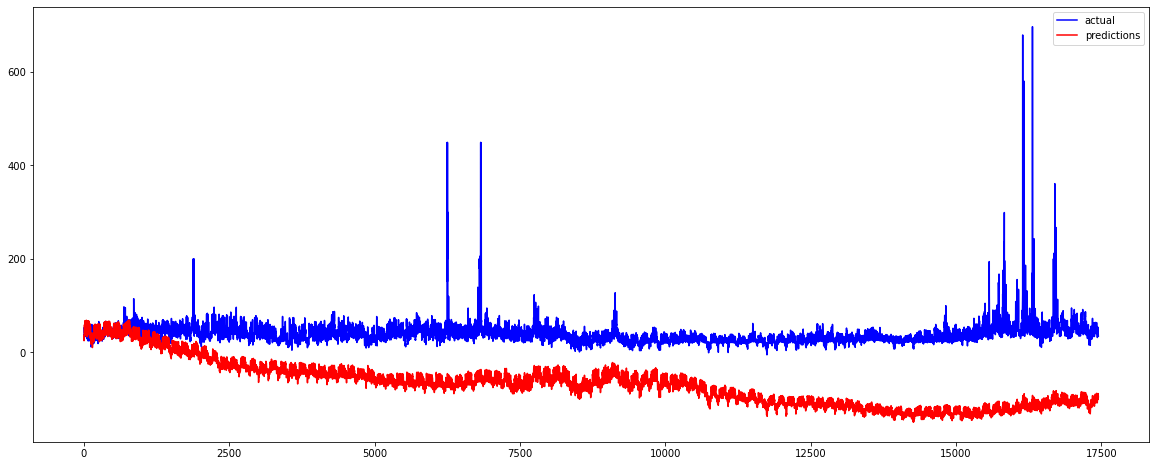

In [69]:
unscaledxgb['actual'].plot(figsize=(20,8), legend=True, color='blue')
unscaledxgb['predictions'].plot(legend=True, color='red', figsize=(20,8))

In [70]:
mape = mean_absolute_percentage_error(unscaledxgb['actual'], unscaledxgb['predictions'])
mape

469.82565444480076

In [84]:
#Save pred results
import csv 
unscaledxgb = pd.DataFrame(unscaled)
unscaled.to_csv("Unscaled_XGB_rslts.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

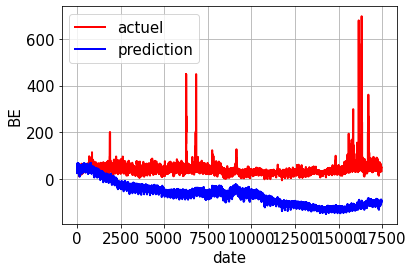

In [83]:
original=unscaledxgb['actual']
pred=unscaledxgb['predictions']
plt.plot(original,'r',lw =2)
plt.plot(pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('XGB', figsize=(20,8), transparent=True, dpi=300)